# Autoencoder: CMS Trigger Rate Monitoring

In [1]:
#import setGPU

import getpass
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle
import tables
import tensorflow as tf

from functools import reduce
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.covariance import empirical_covariance
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda

/home/adpol/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/adpol/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/adpol/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/adpol/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 14
matplotlib.rcParams["ytick.labelsize"] = 14
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},      
                "Blue": {50: "#E3F2FD",
                    100: "#BBDEFB",
                    200: "#90CAF9",
                    300: "#64B5F6",
                    400: "#42A5F5",
                    500: "#2196F3",
                    600: "#1E88E5",
                    700: "#1976D2",
                    800: "#1565C0",
                    900: "#0D47A1"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"},
                 "Lime": {
                    50: "#F9FBE7",
                    100: "#F0F4C3",
                    200: "#E6EE9C",
                    300: "#DCE775",
                    400: "#D4E157",
                    500: "#CDDC39",
                    600: "#C0CA33",
                    700: "#AFB42B",
                    800: "#9E9D24",
                    900: "#827717"},
                "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"},
                 "Red": {
                    50: "#FFEBEE",
                    100: "#FFCDD2",
                    200: "#EF9A9A",
                    300: "#E57373",
                    400: "#EF5350",
                    500: "#F44336",
                    600: "#E53935",
                    700: "#D32F2F",
                    800: "#C62828",
                    900: "#B71C1C"},
                 "Light Green": {
                    50: "#F1F8E9",
                    100: "#DCEDC8",
                    200: "#C5E1A5",
                    300: "#AED581",
                    400: "#9CCC65",
                    500: "#8BC34A",
                    600: "#7CB342",
                    700: "#388E3C",
                    800: "#558B2F",
                    900: "#33691E"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

lines = [(color_palette["Orange"], line_styles[0]),
         (color_palette["Red"], line_styles[0]),
         (color_palette["Blue"], line_styles[2]),
         (color_palette["Light Green"], line_styles[0])]

In [3]:
# Authenticate to use EOS

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [4]:
FIGURE_EXPORT_DIR = "./figures"
MODELS_DIRECTORY = "./model"
VALIDATIONS = 5
LOAD_MODELS = True

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)

## Load and preprocess the data

In [6]:
# Load information about available rates. Collisions from July 2017, to October 2017

rates_info = pd.read_csv("./data/extended-available-trigger-info.csv",
                   dtype={"trigger": str,
                          "trigger_mode": str,
                          "l1_key": str,
                          "hlt_key": str,
                          "run": int,
                          "fill": int},
                   index_col=0)

rates_info.drop_duplicates(inplace=True)

In [7]:
SELECT_L1_TRIGGERS = ['L1_ETM120',
'L1_DoubleMu_15_7_SQ',
'L1_ETMHF150',
'L1_Mu22er2p1_IsoTau36er2p1']

SELECT_HLT_TRIGGERS = ['HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL',
       'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ',
       'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
       'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8',
       'HLT_DoubleMu43NoFiltersNoVtx',
       'HLT_DoubleMu48NoFiltersNoVtx',
                      
       'HLT_PFMET110_PFMHT110_IDTight',
       'HLT_PFMET120_PFMHT120_IDTight',
       'HLT_PFMET130_PFMHT130_IDTight',
       'HLT_PFMET110_PFMHT110_IDTight_CaloBTagCSV_3p1',
       'HLT_PFMET120_PFMHT120_IDTight_CaloBTagCSV_3p1',
       'HLT_PFMET130_PFMHT130_IDTight_CaloBTagCSV_3p1',
                       
       'HLT_PFMETTypeOne120_PFMHT120_IDTight',
       'HLT_PFMETTypeOne130_PFMHT130_IDTight',
       'HLT_PFMETTypeOne140_PFMHT140_IDTight',
       'HLT_PFMETNoMu120_PFMHTNoMu120_IDTight',
       'HLT_PFMETNoMu130_PFMHTNoMu130_IDTight',
       'HLT_PFMETNoMu140_PFMHTNoMu140_IDTight',

       'HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1',
       'HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1',
       'HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1',
       'HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1',
       'HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1',
       'HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1']

SELECT_TRIGGER = SELECT_L1_TRIGGERS + SELECT_HLT_TRIGGERS

In [8]:
label_file = 'data/certification.txt'
output_json = json.load(open(label_file))

def json_checker(orig_runid, orig_lumid):
    try:
        for i in output_json[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

In [9]:
# Load all rates arrays for a given trigger

data_per_run = pd.DataFrame()

for _, sample in rates_info[rates_info.trigger.isin(SELECT_TRIGGER)].iterrows():
    
    try:
        # Load rates from .npy
        readouts = np.load("/eos/cms/store/cmst3/group/dehep/adpol/trigger/extended/%s/%s.npy"
                           % (sample.run, sample.trigger))

        # Save rates to series
        sample["pu"] = readouts[0]
        sample["rates"] = readouts[1]

        # Save detector status to series
        sample["detector_status"] = readouts[2] == 1

        # Save physics status to series
        sample["physics_status"] = readouts[3] == 1

        # Save instantaneous luminosity to series
        sample["instantaneous_luminosity"] = readouts[4]

        # Save lumisection number to series
        sample["lumisection"] = readouts[5]
        
        lumi_flags = []
        for ls in readouts[5]:
            lumi_flags.append(json_checker(sample.run, ls))
        sample["muon_flag"] = np.array(lumi_flags)
        
    except:
        sample["rates"] = np.nan

    data_per_run = data_per_run.append(pd.Series(sample))
    
data_per_run.dropna(inplace=True)

In [10]:
# Alternative

# data_per_run = pd.read_hdf('data.h5', 'dpr')
# data_per_run.dropna(inplace=True)

In [11]:
# Keep only fill that have all triggers recorded

run_to_keep = []

for run in data_per_run.run.unique():
    if len(data_per_run[data_per_run.run == run].trigger.unique()) == len(SELECT_TRIGGER):
        run_to_keep.append(run)
    else:
        for trigger in SELECT_TRIGGER:
            if trigger not in data_per_run[data_per_run.run == run].trigger.unique():
                print(run, trigger)

300281.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL
300281.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
300281.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8
300281.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
300281.0 HLT_DoubleMu43NoFiltersNoVtx
300281.0 HLT_DoubleMu48NoFiltersNoVtx
300281.0 HLT_PFMET110_PFMHT110_IDTight
300281.0 HLT_PFMET120_PFMHT120_IDTight
300281.0 HLT_PFMET130_PFMHT130_IDTight
300281.0 HLT_PFMET110_PFMHT110_IDTight_CaloBTagCSV_3p1
300281.0 HLT_PFMET120_PFMHT120_IDTight_CaloBTagCSV_3p1
300281.0 HLT_PFMET130_PFMHT130_IDTight_CaloBTagCSV_3p1
300281.0 HLT_PFMETTypeOne120_PFMHT120_IDTight
300281.0 HLT_PFMETTypeOne130_PFMHT130_IDTight
300281.0 HLT_PFMETTypeOne140_PFMHT140_IDTight
300281.0 HLT_PFMETNoMu120_PFMHTNoMu120_IDTight
300281.0 HLT_PFMETNoMu130_PFMHTNoMu130_IDTight
300281.0 HLT_PFMETNoMu140_PFMHTNoMu140_IDTight
300281.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
300281.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
300281.0 HLT_I

301473.0 HLT_PFMETNoMu130_PFMHTNoMu130_IDTight
301473.0 HLT_PFMETNoMu140_PFMHTNoMu140_IDTight
301473.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
301473.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
301473.0 HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
301473.0 HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
301473.0 HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
301473.0 HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
301474.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL
301474.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
301474.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8
301474.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
301474.0 HLT_DoubleMu43NoFiltersNoVtx
301474.0 HLT_DoubleMu48NoFiltersNoVtx
301474.0 HLT_PFMET110_PFMHT110_IDTight
301474.0 HLT_PFMET120_PFMHT120_IDTight
301474.0 HLT_PFMET130_PFMHT130_IDTight
301474.0 HLT_PFMET110_PFMHT110_IDTight_CaloBTa

302490.0 HLT_PFMETNoMu120_PFMHTNoMu120_IDTight
302490.0 HLT_PFMETNoMu130_PFMHTNoMu130_IDTight
302490.0 HLT_PFMETNoMu140_PFMHTNoMu140_IDTight
302490.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
302490.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
302490.0 HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
302490.0 HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
302490.0 HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
302490.0 HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
302524.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL
302524.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
302524.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8
302524.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
302524.0 HLT_DoubleMu43NoFiltersNoVtx
302524.0 HLT_DoubleMu48NoFiltersNoVtx
302524.0 HLT_PFMET110_PFMHT110_IDTight
302524.0 HLT_PFMET120_PFMHT120_IDTight
302524.0 HLT_PFMET130_PFMHT130_IDTight

303707.0 HLT_PFMET120_PFMHT120_IDTight
303707.0 HLT_PFMET130_PFMHT130_IDTight
303707.0 HLT_PFMET110_PFMHT110_IDTight_CaloBTagCSV_3p1
303707.0 HLT_PFMET120_PFMHT120_IDTight_CaloBTagCSV_3p1
303707.0 HLT_PFMET130_PFMHT130_IDTight_CaloBTagCSV_3p1
303707.0 HLT_PFMETTypeOne120_PFMHT120_IDTight
303707.0 HLT_PFMETTypeOne130_PFMHT130_IDTight
303707.0 HLT_PFMETTypeOne140_PFMHT140_IDTight
303707.0 HLT_PFMETNoMu120_PFMHTNoMu120_IDTight
303707.0 HLT_PFMETNoMu130_PFMHTNoMu130_IDTight
303707.0 HLT_PFMETNoMu140_PFMHTNoMu140_IDTight
303707.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
303707.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
303707.0 HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
303707.0 HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
303707.0 HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
303707.0 HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
30

303793.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8
303793.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
303793.0 HLT_DoubleMu43NoFiltersNoVtx
303793.0 HLT_DoubleMu48NoFiltersNoVtx
303793.0 HLT_PFMET110_PFMHT110_IDTight
303793.0 HLT_PFMET120_PFMHT120_IDTight
303793.0 HLT_PFMET130_PFMHT130_IDTight
303793.0 HLT_PFMET110_PFMHT110_IDTight_CaloBTagCSV_3p1
303793.0 HLT_PFMET120_PFMHT120_IDTight_CaloBTagCSV_3p1
303793.0 HLT_PFMET130_PFMHT130_IDTight_CaloBTagCSV_3p1
303793.0 HLT_PFMETTypeOne120_PFMHT120_IDTight
303793.0 HLT_PFMETTypeOne130_PFMHT130_IDTight
303793.0 HLT_PFMETTypeOne140_PFMHT140_IDTight
303793.0 HLT_PFMETNoMu120_PFMHTNoMu120_IDTight
303793.0 HLT_PFMETNoMu130_PFMHTNoMu130_IDTight
303793.0 HLT_PFMETNoMu140_PFMHTNoMu140_IDTight
303793.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
303793.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
303793.0 HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
303793.0 HLT_IsoMu24_eta2

304763.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL
304763.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
304763.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8
304763.0 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
304763.0 HLT_DoubleMu43NoFiltersNoVtx
304763.0 HLT_DoubleMu48NoFiltersNoVtx
304763.0 HLT_PFMET110_PFMHT110_IDTight
304763.0 HLT_PFMET120_PFMHT120_IDTight
304763.0 HLT_PFMET130_PFMHT130_IDTight
304763.0 HLT_PFMET110_PFMHT110_IDTight_CaloBTagCSV_3p1
304763.0 HLT_PFMET120_PFMHT120_IDTight_CaloBTagCSV_3p1
304763.0 HLT_PFMET130_PFMHT130_IDTight_CaloBTagCSV_3p1
304763.0 HLT_PFMETTypeOne120_PFMHT120_IDTight
304763.0 HLT_PFMETTypeOne130_PFMHT130_IDTight
304763.0 HLT_PFMETTypeOne140_PFMHT140_IDTight
304763.0 HLT_PFMETNoMu120_PFMHTNoMu120_IDTight
304763.0 HLT_PFMETNoMu130_PFMHTNoMu130_IDTight
304763.0 HLT_PFMETNoMu140_PFMHTNoMu140_IDTight
304763.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1
304763.0 HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1
304763.0 HLT_I

In [12]:
# Removed runs

print(", ".join([str(int(x)) for x in list(set(data_per_run.run.unique()) - set(run_to_keep))]))

303744, 304769, 304770, 304013, 300309, 302486, 302487, 302488, 302489, 302490, 303772, 301087, 301983, 301473, 301474, 303790, 303793, 303794, 303795, 304435, 302524, 302015, 301120, 303813, 300361, 304458, 304460, 304463, 304465, 301395, 303699, 300372, 303702, 300499, 302550, 300501, 303706, 303707, 302044, 304475, 303712, 303714, 303718, 303719, 300401, 303734, 302839, 300281, 304763, 303741


In [13]:
# Remove runs

data_per_run = data_per_run[data_per_run.run.isin(run_to_keep)]

In [14]:
# Filter physics data

def filter_physics(array, physics_status, detector_status):
    return array[physics_status & detector_status]

data_per_run.loc[:, "lumisection_filtered"] = data_per_run.apply(lambda row: filter_physics(row["lumisection"],
                                                                                     row["detector_status"],
                                                                                     row["physics_status"]), axis=1)

data_per_run.loc[:, "pu_filtered"] = data_per_run.apply(lambda row: filter_physics(row["pu"],
                                                                            row["detector_status"],
                                                                            row["physics_status"]), axis=1)

data_per_run.loc[:, "rates_filtered"] = data_per_run.apply(lambda row: filter_physics(row["rates"],
                                                                               row["detector_status"],
                                                                               row["physics_status"]), axis=1)

data_per_run.loc[:, "muon_flag_filtered"] = data_per_run.apply(lambda row: filter_physics(row["muon_flag"],
                                                                                   row["detector_status"],
                                                                                   row["physics_status"]), axis=1)

In [15]:
for run in data_per_run["run"].unique():
    
    # Find common LSs
    common_lss = reduce(np.intersect1d,
                        tuple(data_per_run[data_per_run.run == run]["lumisection_filtered"].values))
    
    for trigger in SELECT_TRIGGER:
        sample = data_per_run[(data_per_run["run"] == run) & (data_per_run["trigger"] == trigger)]

        # Find a filter for this sample
        foo_filter = [i in common_lss for i in sample["lumisection_filtered"].values[0]]
        
        if not foo_filter:
            continue
            
        data_per_run.loc[sample.index, "lumisection_trimmed"] = pd.Series([sample["lumisection_filtered"].values[0][foo_filter]]).values
        data_per_run.loc[sample.index, "pu_trimmed"] = pd.Series([sample["pu_filtered"].values[0][foo_filter]]).values
        data_per_run.loc[sample.index, "rates_trimmed"] = pd.Series([sample["rates_filtered"].values[0][foo_filter]]).values
        data_per_run.loc[sample.index, "muon_flag_trimmed"] = pd.Series([sample["muon_flag_filtered"].values[0][foo_filter]]).values

In [16]:
data_per_run.dropna(inplace=True)

In [17]:
print(len(np.concatenate(data_per_run.lumisection.values)))
print(len(np.concatenate(data_per_run.lumisection_filtered.values)))
print(len(np.concatenate(data_per_run.lumisection_trimmed.values)))

3339691
3069285
3040100


In [18]:
# Keep only fill that have all triggers recorded

fill_to_keep = []

for fill in data_per_run.fill.unique():
    if len(data_per_run[data_per_run.fill == fill].trigger.unique()) == len(SELECT_TRIGGER):
        fill_to_keep.append(fill)

In [19]:
# How many fills will be trashed?

print("%s out of %s" % (len(data_per_run.fill.unique()) - len(fill_to_keep),
                        len(data_per_run.fill.unique())))

0 out of 106


In [20]:
# Keep only fill that have all triggers recorded part 2

data_per_run = data_per_run[data_per_run.fill.isin(fill_to_keep)]

In [21]:
# Change from per run to per fill

data_per_fill = pd.DataFrame()

for fill in fill_to_keep:
    for trigger in SELECT_TRIGGER:
        sample = data_per_run[(data_per_run.fill == fill) & (data_per_run.trigger == trigger)]
       
        pu = np.hstack(sample["pu_trimmed"].values)
        rates = np.hstack(sample["rates_trimmed"].values)
        lumisection = np.hstack(sample["lumisection_trimmed"].values)
        muon_flag = np.hstack(sample["muon_flag_trimmed"].values)
        
        data_per_fill = data_per_fill.append(pd.Series({"trigger": trigger,
                                                        "pu": pu,
                                                        "rates": rates,
                                                        "lumisection": lumisection,
                                                        "muon_flag": muon_flag,
                                                        "fill": fill,
                                                        "runs": ";".join([str(i) for i in sample.run.unique().tolist()])}),
                                             ignore_index=True)

In [22]:
# Remove <PU> < 15

def filter_pu(array, pus):
    return array[pus > 15]

for s in ["rates", "lumisection", "muon_flag", "pu"]:
    data_per_fill[s] = data_per_fill.apply(lambda row: filter_pu(row[s],
                                                                 row["pu"]), axis=1)


In [23]:
def sanity_check(x, name, fill):
    if name == "L1_ETMHF150":
        if np.max(x) > 100:
            print(fill)
        
data_per_fill.apply(lambda row: sanity_check(row["rates"], row["trigger"],
                                              row["fill"]), axis=1);

6141.0
6169.0
6238.0
6239.0


In [24]:
# Remove fills with abnormal values

data_per_fill = data_per_fill[(data_per_fill.fill != 6238) &
                              (data_per_fill.fill != 6239) &
                              (data_per_fill.fill != 6141) &
                              (data_per_fill.fill != 6169)]

In [25]:
for _, sample in data_per_fill[data_per_fill.trigger == SELECT_TRIGGER[0]].iterrows():
    if len(list(set(sample.muon_flag))) == 2:
        print("Fill %d: %d LS (%d bad)" %
              (sample.fill,
               len(sample.muon_flag),
               len([i for i in sample.muon_flag if i == 1])))

Fill 6024: 1835 LS (195 bad)
Fill 6052: 1337 LS (96 bad)
Fill 6060: 1825 LS (21 bad)
Fill 6165: 552 LS (7 bad)
Fill 6186: 1523 LS (13 bad)
Fill 6245: 1643 LS (29 bad)


L1_ETM120


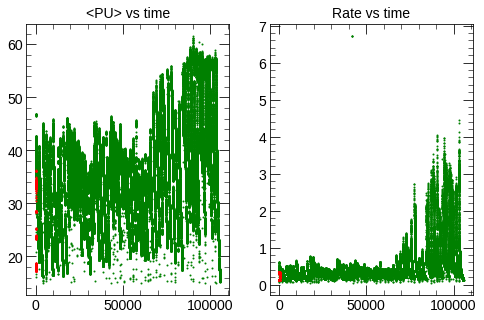

L1_DoubleMu_15_7_SQ


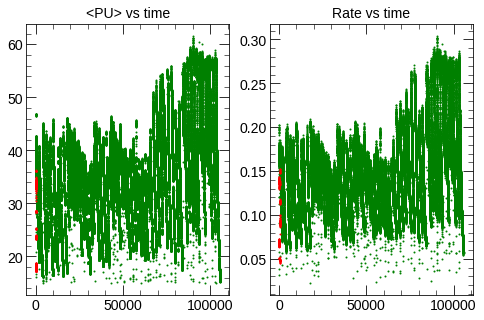

L1_ETMHF150


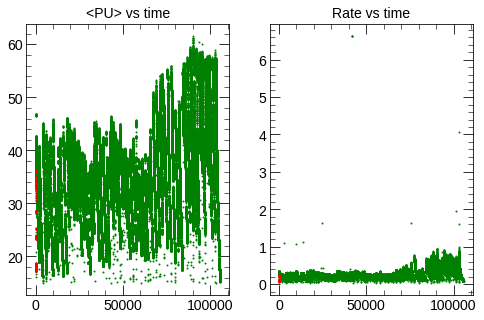

L1_Mu22er2p1_IsoTau36er2p1


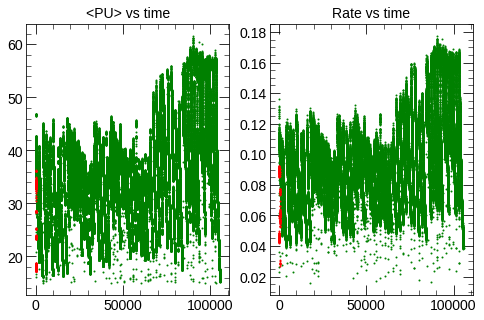

HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL


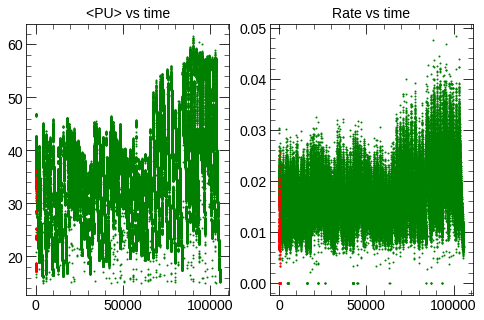

HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ


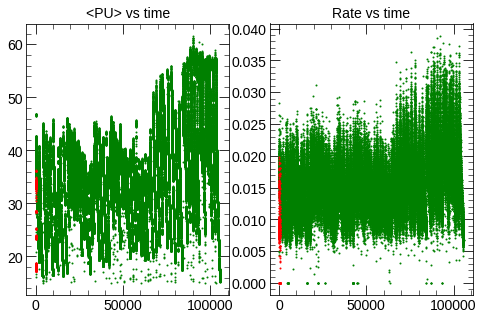

HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8


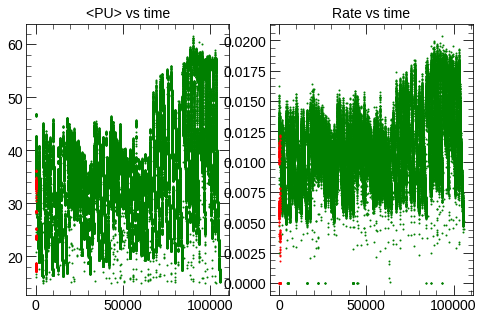

HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8


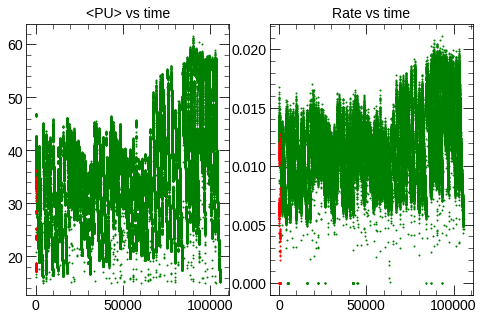

HLT_DoubleMu43NoFiltersNoVtx


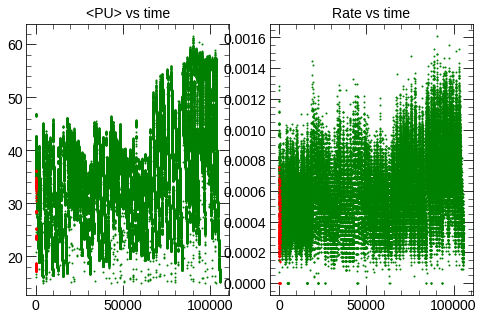

HLT_DoubleMu48NoFiltersNoVtx


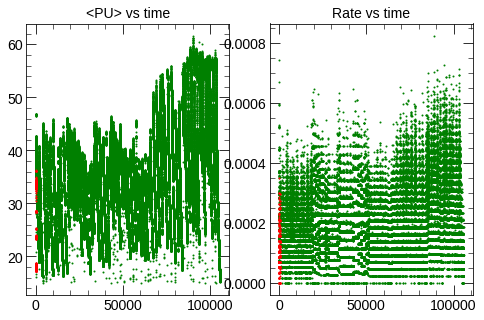

HLT_PFMET110_PFMHT110_IDTight


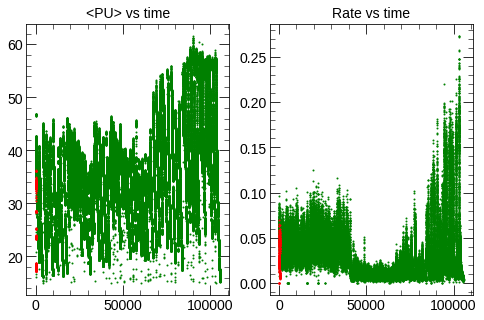

HLT_PFMET120_PFMHT120_IDTight


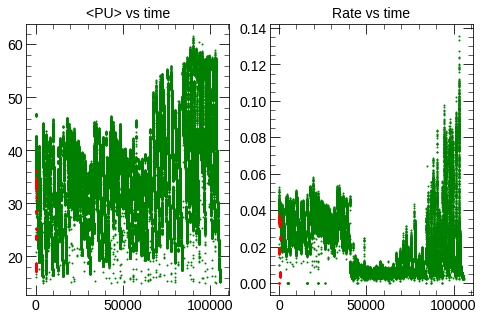

HLT_PFMET130_PFMHT130_IDTight


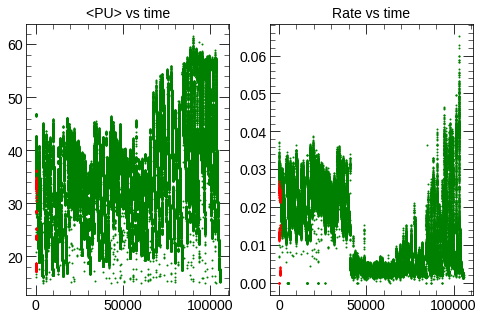

HLT_PFMET110_PFMHT110_IDTight_CaloBTagCSV_3p1


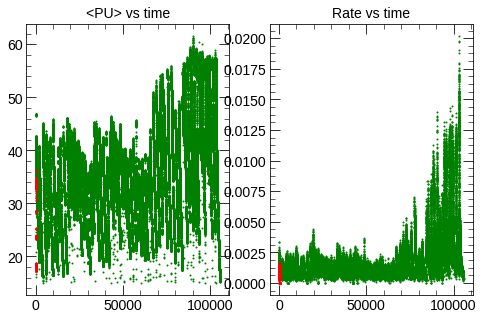

HLT_PFMET120_PFMHT120_IDTight_CaloBTagCSV_3p1


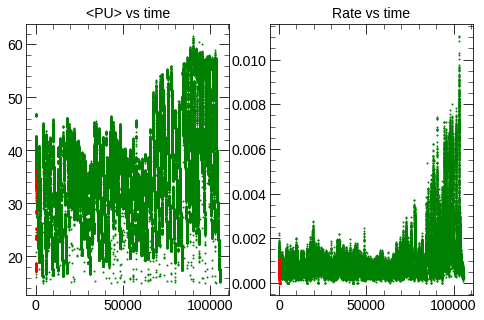

HLT_PFMET130_PFMHT130_IDTight_CaloBTagCSV_3p1


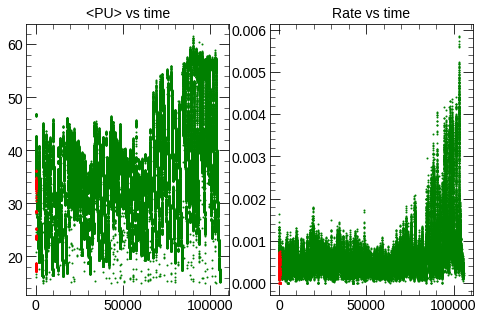

HLT_PFMETTypeOne120_PFMHT120_IDTight


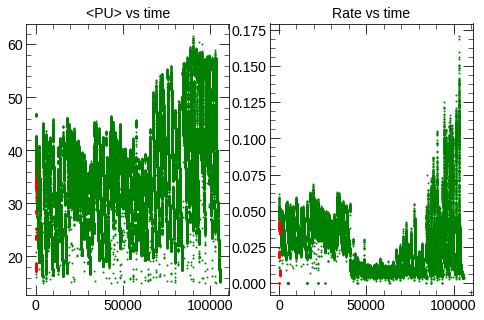

HLT_PFMETTypeOne130_PFMHT130_IDTight


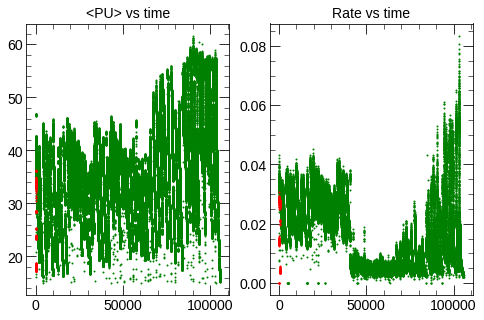

HLT_PFMETTypeOne140_PFMHT140_IDTight


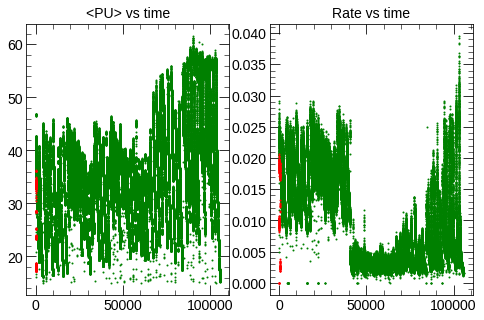

HLT_PFMETNoMu120_PFMHTNoMu120_IDTight


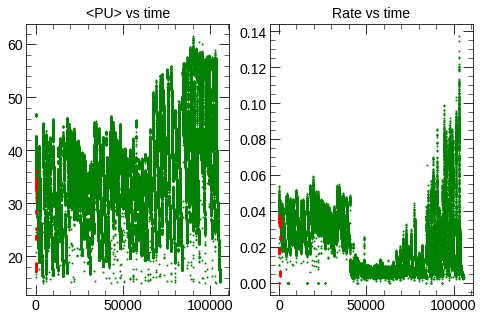

HLT_PFMETNoMu130_PFMHTNoMu130_IDTight


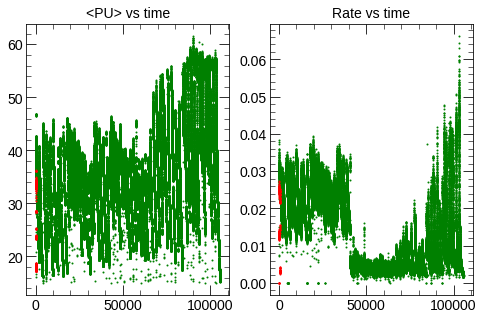

HLT_PFMETNoMu140_PFMHTNoMu140_IDTight


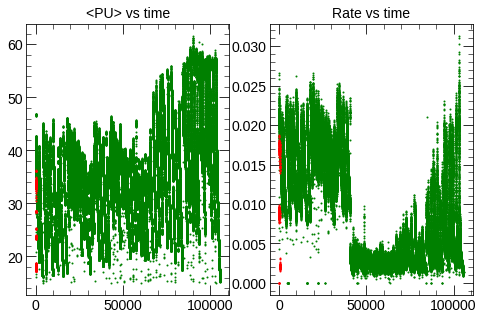

HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1


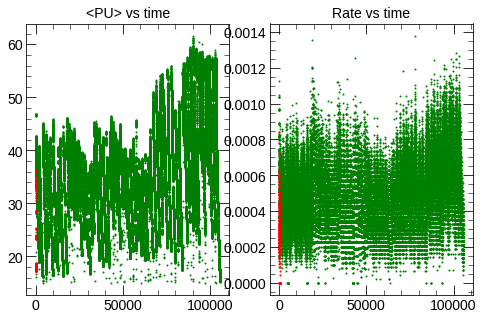

HLT_IsoMu24_eta2p1_LooseChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1


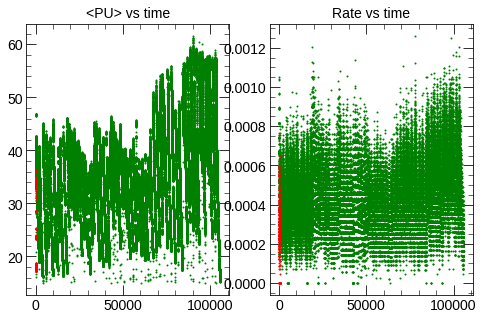

HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1


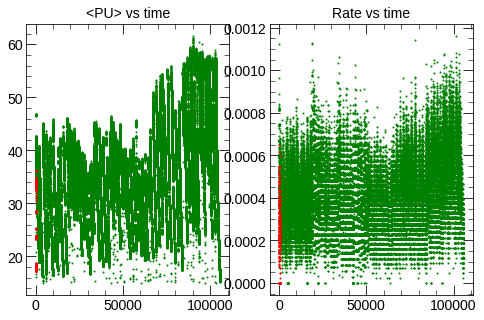

HLT_IsoMu24_eta2p1_MediumChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1


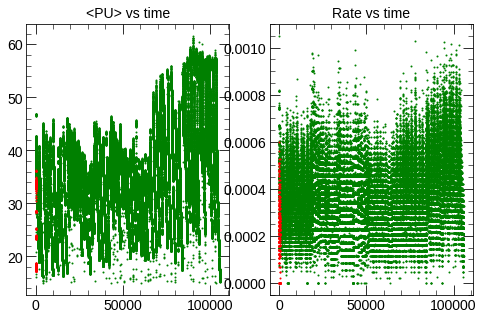

HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_eta2p1_Reg_CrossL1


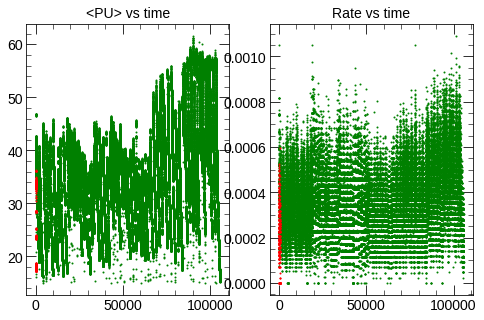

HLT_IsoMu24_eta2p1_TightChargedIsoPFTau35_Trk1_TightID_eta2p1_Reg_CrossL1


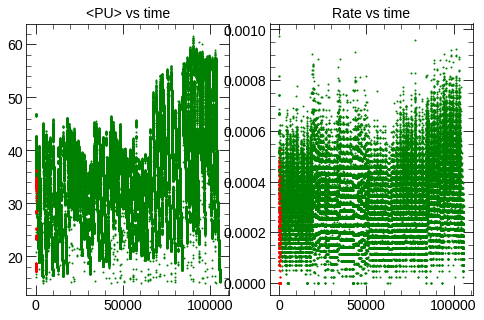

In [26]:
# Plot the available data

for i in range(len(SELECT_TRIGGER)):
    print(SELECT_TRIGGER[i])

    sample_l1 = data_per_fill[(data_per_fill.trigger == SELECT_TRIGGER[i])]

    pu = sample_l1["pu"].values
    rate = sample_l1["rates"].values
    goodness = sample_l1["muon_flag"].values

    pu = np.hstack(pu)
    rate = np.hstack(rate)
    goodness = np.hstack(goodness)
    goodness = [i == 0 for i in goodness]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = range(len(pu))

    ax1.plot(pu[goodness], 'o', markersize=1, color="green")
    ax1.plot(pu[np.logical_not(goodness)], 'o', markersize=1, color="red")
    ax1.set_title('<PU> vs time')
    ax2.plot(rate[goodness], 'o', markersize=1, color="green")
    ax2.plot(rate[np.logical_not(goodness)], 'o', markersize=1, color="red")
    ax2.set_title('Rate vs time')
    
    plt.show()

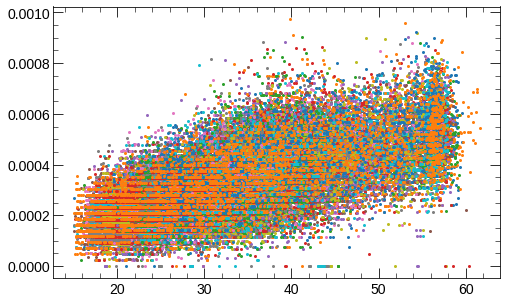

In [27]:
for _, row in sample_l1.iterrows():
    plt.plot(row["pu"], row["rates"], '.', markersize=4, label=row.fill)
plt.show()

## Calculate trends and sigmas for the test set

In [28]:
# Generate fits

def regress_data(rates, pu, mask):
    model = Pipeline([("poly", PolynomialFeatures(degree=4)),
                      ("linear", LinearRegression(fit_intercept=False))])
    mask = [i == 0 for i in mask]
    model.fit(pu[mask].reshape(-1, 1), rates[mask].reshape(-1, 1))
    return "%s+x*%s+x*x*%s+x*x*x*%s+x*x*x*x*%s" % tuple(model.named_steps["linear"].coef_[0])

def eval_function(x, function):
    if not len(function):
        return np.nan
    return eval(function)

def get_normalized_data(x, rates):
    flattened = x - rates
    return flattened / np.std(flattened)

In [29]:
data_per_fill["close_fit"] = data_per_fill.apply(lambda row: regress_data(row["rates"],
                                                                          row["pu"],
                                                                          row["muon_flag"]), axis=1)

data_per_fill["eval_close_fit"] = data_per_fill.apply(lambda row: eval_function(row["pu"],
                                                                                row["close_fit"]), axis=1)

data_per_fill["norm_close_fit"] = data_per_fill.apply(lambda row: get_normalized_data(row["eval_close_fit"],
                                                                                      row["rates"]), axis=1)

## Prepare the data

In [30]:
HLTs = [t for t in SELECT_TRIGGER if t.startswith("HLT")]
L1Ts = [t for t in SELECT_TRIGGER if t.startswith("L1")]

In [31]:
# Train test split

test_fills = np.array([6291])
train_fills = data_per_fill.fill.unique()[np.isin(data_per_fill.fill.unique(), test_fills, invert=True)]

In [32]:
x_train = np.empty((0, len(HLTs)))
x_train_encoded_l1 = np.empty((0, len(L1Ts)))
x_train_encoded_flags = np.empty((0, 1))
    
for fill in train_fills:
    readouts_flags = list()
    
    readouts_hlt = np.transpose(np.stack(
        data_per_fill[(data_per_fill.fill == fill) &
                      (data_per_fill.trigger.isin(HLTs))].norm_close_fit.values))
    
    readouts_l1 = np.transpose(np.stack(
        data_per_fill[(data_per_fill.fill == fill) &
                      (data_per_fill.trigger.isin(L1Ts))].norm_close_fit.values))
    
    readouts_flags = np.transpose(np.stack(
        data_per_fill[(data_per_fill.fill == fill) &
                      (data_per_fill.trigger == HLTs[0])].muon_flag.values))

    x_train = np.append(x_train,
                        readouts_hlt,
                        axis=0)
    
    x_train_encoded_l1 = np.append(x_train_encoded_l1,
                                   readouts_l1,
                                   axis=0)
    
    x_train_encoded_flags = np.append(x_train_encoded_flags,
                                      readouts_flags.reshape(-1, 1),
                                      axis=0)

In [33]:
x_train_encoded_flags = x_train_encoded_flags == 0
x_train = x_train[x_train_encoded_flags.repeat(24, axis=1)].reshape(-1, 24)
x_train_encoded_l1 = x_train_encoded_l1[x_train_encoded_flags.repeat(4, axis=1)].reshape(-1, 4)

print(x_train.shape)
print(x_train_encoded_l1.shape)

(102895, 24)
(102895, 4)


In [34]:
x_test = np.empty((0, len(HLTs)))
x_test_encoded_l1 = np.empty((0, len(L1Ts)))
x_test_encoded_flags = np.empty((0, 1))
    
for fill in test_fills:
    readouts_flags = list()
    
    readouts_hlt = np.transpose(np.stack(
        data_per_fill[(data_per_fill.fill == fill) &
                      (data_per_fill.trigger.isin(HLTs))].norm_close_fit.values))
    
    readouts_l1 = np.transpose(np.stack(
        data_per_fill[(data_per_fill.fill == fill) &
                      (data_per_fill.trigger.isin(L1Ts))].norm_close_fit.values))
    
    readouts_flags = np.transpose(np.stack(
        data_per_fill[(data_per_fill.fill == fill) &
                      (data_per_fill.trigger == HLTs[0])].muon_flag.values))

    x_test = np.append(x_test,
                        readouts_hlt,
                        axis=0)
    
    x_test_encoded_l1 = np.append(x_test_encoded_l1,
                                   readouts_l1,
                                   axis=0)
    
    x_test_encoded_flags = np.append(x_test_encoded_flags,
                                      readouts_flags.reshape(-1, 1),
                                      axis=0)

In [35]:
print(x_test.shape)
print(x_test_encoded_l1.shape)

(2800, 24)
(2800, 4)


#### Define Plotting Magic

In [36]:
# Plot Rate vs <PU>

def PlotTriggerTolerance(ax, sample, what=None, standardised_error=False, sigma=None, foo=None):
    pu = sample["pu"]
    mask = sample["muon_flag"]
    mask = [i == 0 for i in mask]
    
    if standardised_error:
        y = abs(sample[foo] - sample.rates) / (sample[sigma])
    else:
        y = sample.rates
    
    ax.plot(pu[mask],
            y[mask],
            'o',
            color=color_palette["Indigo"][400],
            markersize=2)
    
    ax.plot(pu[np.logical_not(mask)],
            y[np.logical_not(mask)],
            'o',
            color=color_palette["Orange"][900],
            markersize=2)
    
    if what:
        what = sample[what]
        if type(what) == str:
            x = sample.pu
            prediction = eval(what)
        else:
            prediction = what

        ax.plot(sorted(sample.pu),
                prediction[np.argsort(sample.pu)],
                '-',
                color=color_palette["Orange"][900],
                linewidth=2,
                alpha=0.5)
    
    ax.set_xlim([15,65])
    ax.set_xlabel("Average PU", horizontalalignment="right", x=1.0)
    
#     ax.fill_between(x,
#                     (prediction+sample.sigma)[np.argsort(sample.pu)],
#                     (prediction-sample.sigma)[np.argsort(sample.pu)],
#                     color=color_palette["Orange"][400],
#                     alpha=0.5)

In [37]:
def plot_loss(data, keys, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Loss", horizontalalignment='right', y=1.0)

    for x, cost in enumerate(keys.keys()):
        color = [*color_palette][x]
        
        val_cost = "val_%s" % cost
        val_label = "Validation %s" % keys[cost]
        
        plt.plot(data[cost],
                 linestyle=line_styles[0],
                 color=color_palette[color][900],
                 label=keys[cost])
        plt.plot(data[val_cost],
                 linestyle=line_styles[2],
                 color=color_palette[color][300],
                 label=val_label)
        
    plt.legend(loc="upper right", frameon=False)
    plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (FIGURE_EXPORT_DIR, save_name), bbox_inches="tight")

    plt.show();

In [38]:
# Plot Rate vs <PU>

def plot_trigger(ax, sample, data):
   
    ax.plot(sample.pu,
            sample.rates,
            'o',
            color=color_palette["Indigo"][400],
            markersize=1)
    
    x = sample.pu

    prediction = eval(sample.prediciton_historical)   
    ax.plot(x,
            prediction,
            '-',
            color=color_palette["Orange"][900],
            linewidth=2,
            alpha=0.5)
    
    ax.plot(sorted(sample.pu)[WINDOW-1:],
            sample[data][np.argsort(sample.pu)][WINDOW-1:],
            '-',
            color=color_palette["Light Green"][900],
            linewidth=2,
            alpha=0.8)

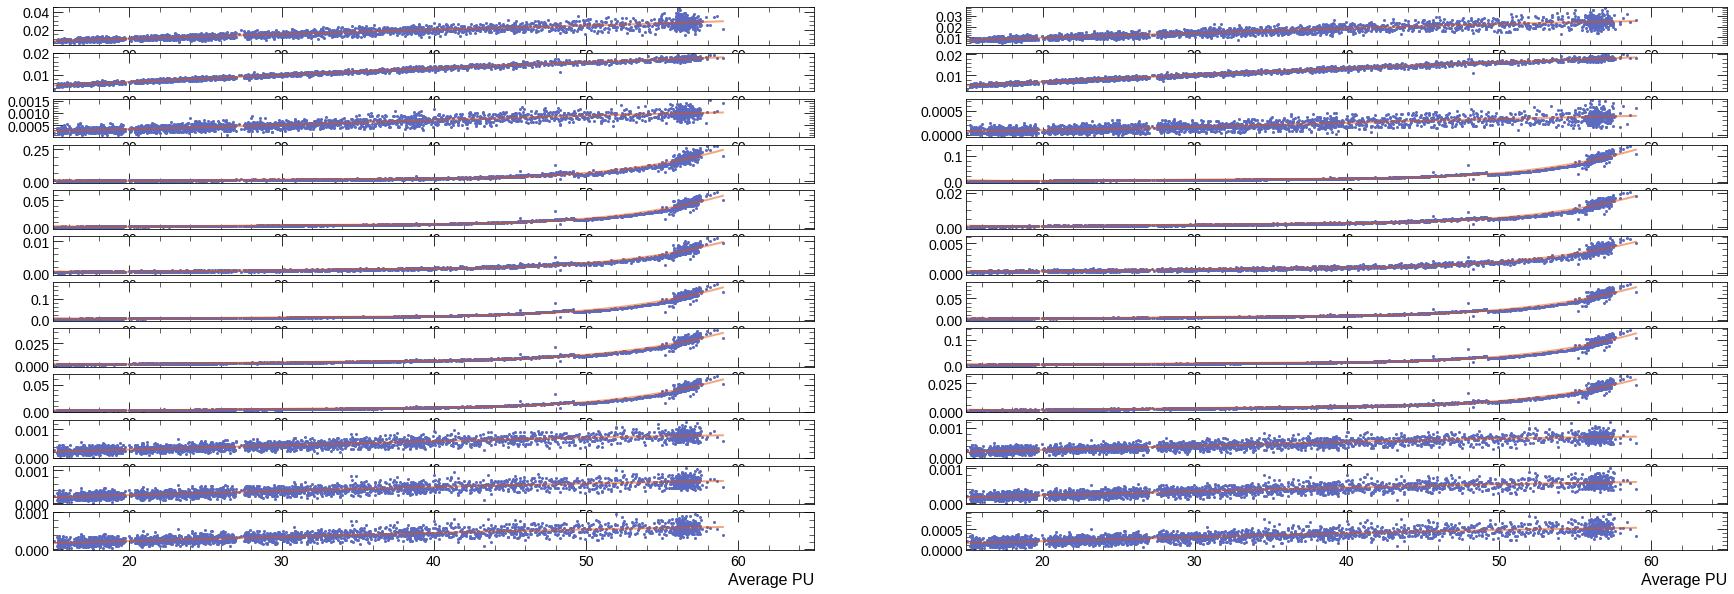

<Figure size 576x360 with 0 Axes>

In [39]:
# HLTs with regressed fit line and marked lumisections

fig = plt.figure(figsize=(30.0, 10.0))

plt.figure()

for x, hlt in enumerate(HLTs):
    sample = data_per_fill[(data_per_fill.fill == fill) & (data_per_fill.trigger == hlt)].iloc[0]
    ax = fig.add_subplot(12, 2, x+1)
    #ax.set_title("%s" % (sample.trigger[:25]))
    PlotTriggerTolerance(ax, sample, "close_fit")
plt.show();

<Figure size 1080x720 with 0 Axes>

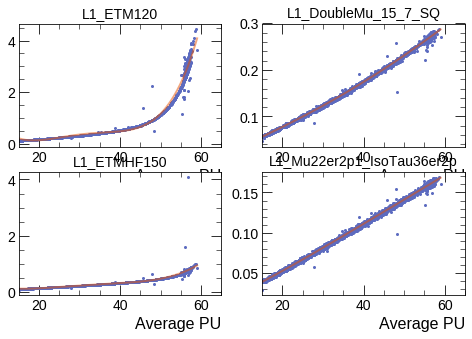

In [40]:
# L1s with regressed fit line and marked lumisections

plt.figure(figsize=(15.0, 10.0))
fig = plt.figure()
for x, l1 in enumerate(L1Ts):
    sample = data_per_fill[(data_per_fill.fill == fill) & (data_per_fill.trigger == l1)].iloc[0]
    ax = fig.add_subplot(2, 2, x+1)
    ax.set_title("%s" % (sample.trigger[:25]))
    PlotTriggerTolerance(ax, sample, "close_fit")
plt.show();

## General Methods for Deep Learning

In [44]:
def train_nn(model, x, y, batch_size, loss, name, validation_split=0.0, metrics=None):

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
   
    checkpoint_callback = ModelCheckpoint(("%s/%s.h5" % (MODELS_DIRECTORY, name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          mode="min")
    
    opt = keras.optimizers.Adam(lr=0.001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=None,
                                decay=0.0,
                                amsgrad=False)
    
    model.compile(loss=loss, metrics=metrics, optimizer=opt)
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=0,
                     initial_epoch=0,
                     shuffle=True,
                     validation_split=validation_split,
                     callbacks=[early_stopper, checkpoint_callback])

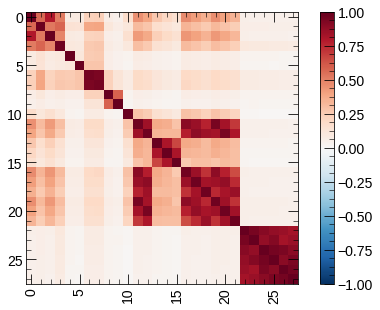

In [41]:
full_thing = np.append(x_train_encoded_l1, x_train, axis=1)
X = full_thing.copy()

from sklearn.covariance import empirical_covariance
emp_cov = empirical_covariance(X)

fig = plt.figure()
vmax = emp_cov.max()
plt.imshow(emp_cov, interpolation='nearest', vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

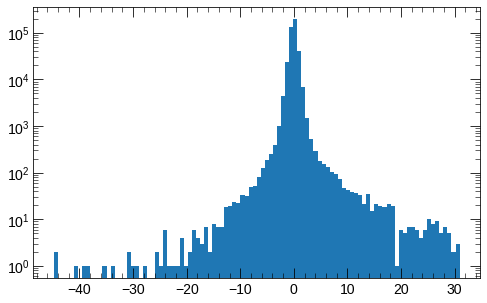

In [42]:
plt.hist(x_train_encoded_l1.flatten(), bins=100)
plt.yscale("log")

## Force encoded L1T and PU with additional free space

In [43]:
# VAE Helpers

from keras import losses

def vae_loss(y_true, y_pred):
    return gaussian_loss(y_true, y_pred) + kld_loss(y_true, y_pred)

def vanilla_vae_loss(y_true, y_pred):
    return losses.mean_squared_error(y_true, y_pred) + kld_loss2(y_true, y_pred)

def gaussian_loss(y_true, y_pred):
    return K.sum(0.5 * K.square(K.tf.divide((y_true - y_pred), K.exp(0.5 * outputs_log_var)))
                 + K.log(np.sqrt(2*np.pi)*K.exp(0.5 * outputs_log_var)),
                 axis=-1)

def kld_loss(y_true, y_pred):
    return -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
                        axis=-1)

def kld_loss2(y_true, y_pred):
    return -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
                        axis=-1)

def sampling(args):
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return mean + K.exp(0.5*log_var) * epsilon

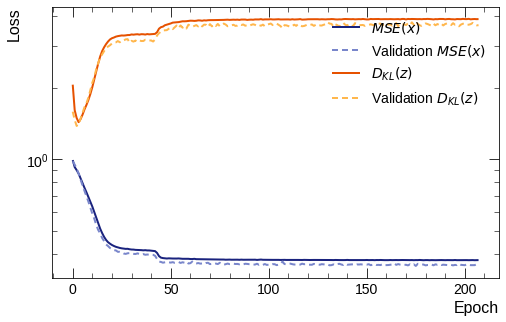

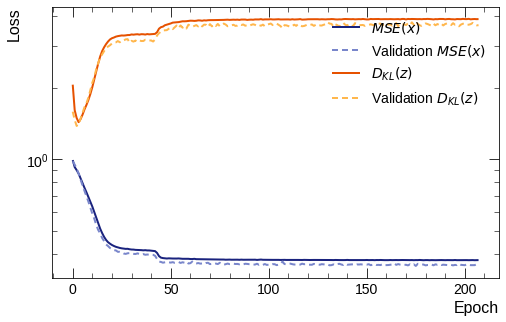

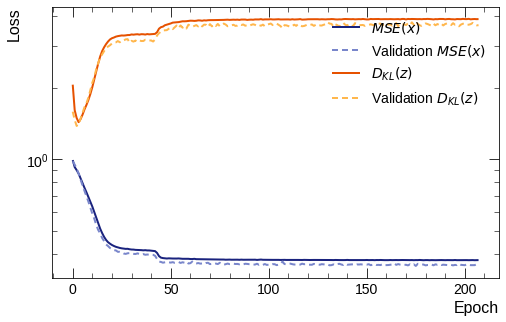

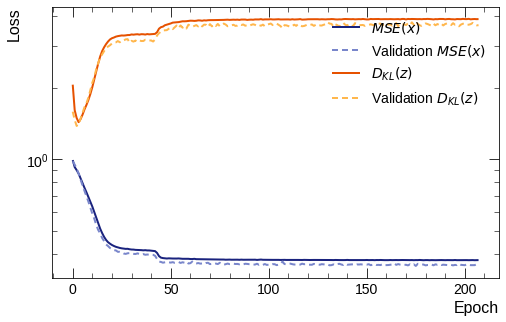

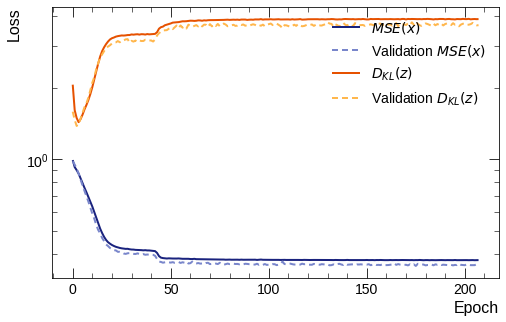

In [44]:
model_name = "model-trigger-rates-dataset2"

original_dim = 24
intermediate_dim = 10
k_latent_dim = 4
z_latent_dim = 4

input_shape=(original_dim,)

vaes = []
vaes_std = []
vaes_encoder = []

for i in range(VALIDATIONS):
    
    redo = True
    
    while redo:
        file_dir = "%s/%s-%s.h5" % (MODELS_DIRECTORY, model_name, i)
        
        inputs = Input(shape=input_shape, name='encoder_input')
        auxiliary_input = Input(shape=(k_latent_dim,), name="auxiliary_input")
        inputs_concatenated = keras.layers.concatenate([inputs, auxiliary_input], name='inputs')

        x = Dense(intermediate_dim, activation="elu")(inputs_concatenated)
        x = Dense(intermediate_dim, activation="elu")(x)

        z_mean = Dense(z_latent_dim, name='z_mean')(x)
        z_log_var = Dense(z_latent_dim, name='z_log_var')(x)
        z_t = Lambda(sampling, output_shape=(z_latent_dim,), name='z')([z_mean, z_log_var])

        encoder = Model(inputs=[inputs, auxiliary_input], outputs=[z_mean, z_log_var, z_t], name='encoder')
        bottleneck = keras.layers.concatenate([encoder([inputs, auxiliary_input])[2], auxiliary_input], name='z_sampling')

        x = Dense(intermediate_dim, activation="elu")(bottleneck)
        x = Dense(intermediate_dim, activation="elu")(x)
        outputs_mean = Dense(original_dim, name="output_mean")(x)
        outputs_log_var = Dense(original_dim, name="output_log_var")(x)

        vae = Model(inputs=[inputs, auxiliary_input], outputs=outputs_mean)
        vae_std = Model(inputs=[inputs, auxiliary_input], outputs=outputs_log_var)
        
        if not LOAD_MODELS and i in [3]:

            history = train_nn(vae,
                               {"encoder_input": x_train, "auxiliary_input": x_train_encoded_l1},
                               x_train,
                               128,
                               vae_loss,
                               "%s-%s" % (model_name, i),
                               metrics=[kld_loss, "mse"],
                               validation_split=0.25).history
            
            vae_std.save_weights("%s/%s-%s-std.h5" % (MODELS_DIRECTORY, model_name, i))
            
            with open("%s/history-%s.pkl" % (MODELS_DIRECTORY, model_name), "wb+") as h:
                pickle.dump(history, h)
            
            redo = (np.isnan(history["loss"][0])) | (history["kld_loss"][-1] < 0)
        else:
            redo = False
        
    vae.load_weights(file_dir)
    vae_std.load_weights("%s/%s-%s-std.h5" % (MODELS_DIRECTORY, model_name, i))
    
    vaes.append(vae)
    vaes_std.append(vae_std)
    vaes_encoder.append(encoder)
    
    with open("%s/history-%s.pkl" % (MODELS_DIRECTORY, model_name), "rb") as history:
        history = pickle.load(history)
        
    plot_loss(history, {"mean_squared_error": "$MSE(x)$", "kld_loss": "$D_{KL}(z)$"}, "loss")

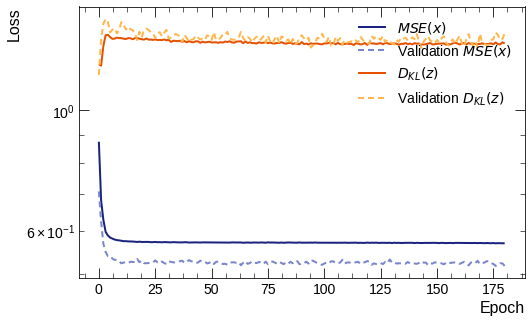

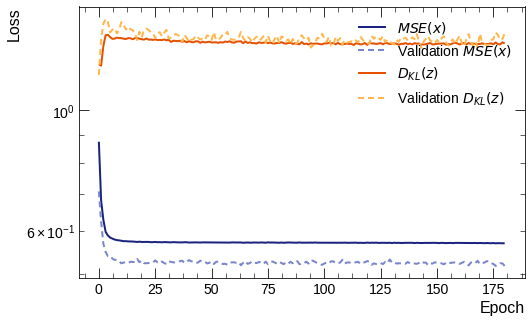

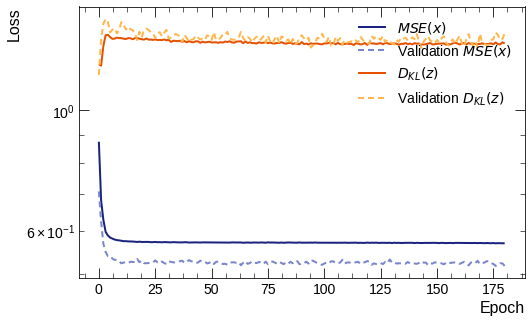

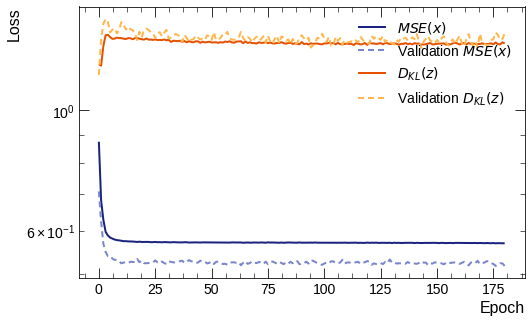

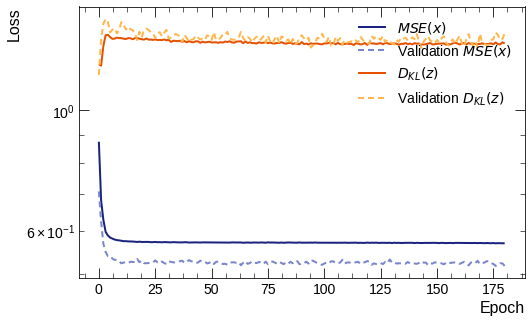

In [45]:
model_name = "model-trigger-rates-dataset-vanilla"

original_dim = 24
intermediate_dim = 10
k_latent_dim = 4
z_latent_dim = 4

input_shape=(original_dim,)

standard_vaes = []
standard_vaes_encoder = []

for i in range(VALIDATIONS):
    
    redo = True
    
    while redo:

        file_dir = "%s/%s-%s.h5" % (MODELS_DIRECTORY, model_name, i)
        
        inputs = Input(shape=input_shape, name='encoder_input')

        x = Dense(intermediate_dim, activation="elu")(inputs)
        x = Dense(intermediate_dim, activation="elu")(x)

        z_mean = Dense(z_latent_dim+k_latent_dim, name='z_mean')(x)
        z_log_var = Dense(z_latent_dim+k_latent_dim, name='z_log_var')(x)
        z_t = Lambda(sampling, output_shape=(z_latent_dim+k_latent_dim,), name='z')([z_mean, z_log_var])

        encoder = Model(inputs=inputs, outputs=[z_mean, z_log_var, z_t], name='encoder')
        
        x = Dense(intermediate_dim, activation="elu")(encoder(inputs)[2])
        x = Dense(intermediate_dim, activation="elu")(x)
        
        outputs_mean = Dense(original_dim, name="output_mean")(x)
        vae = Model(inputs=inputs, outputs=outputs_mean)
        
        if not LOAD_MODELS and i in [7]:

            history = train_nn(vae,
                               {"encoder_input": x_train},
                               x_train,
                               128,
                               vanilla_vae_loss,
                               "%s-%s" % (model_name, i),
                               metrics=[kld_loss, "mse"],
                               validation_split=0.25).history
            
            with open("%s/history-%s.pkl" % (MODELS_DIRECTORY, model_name), "wb+") as h:
                pickle.dump(history, h)

            redo = (np.isnan(history["loss"][0])) | (history["kld_loss"][-1] < 0)
        else:
            redo = False

    vae.load_weights(file_dir)
    
    standard_vaes.append(vae)
    standard_vaes_encoder.append(encoder)
    
    with open("%s/history-%s.pkl" % (MODELS_DIRECTORY, model_name), "rb") as history:
        history = pickle.load(history)
        
    plot_loss(history, {"mean_squared_error": "$MSE(x)$", "kld_loss": "$D_{KL}(z)$"}, "loss")

## Evaluation: Generate Test Set

In [46]:
# Define distribution drawing function

def get_distribution(distr1, distr2, label1, label2, binmax, binmin=0, binnum=50):

    binBoundaries = np.linspace(binmin, binmax, binnum);

    plt.hist(distr1,
             color='#aabbcd',
             bins=binBoundaries,
             linewidth=2,
             label=label1);

    plt.hist(distr2,
             edgecolor='#b51a2c',
             histtype = 'step',
             bins=binBoundaries,
             facecolor='None',
             linewidth=2,
             label=label2);
    
    plt.legend();

In [47]:
# ROC curve plotting function

def get_roc_curve(decision_score_arr, y_test_arr, label_arr, smoothness=1000, save_name=False):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    for j in range(3):
        decision_score = decision_score_arr[j]
        y_test = y_test_arr[j]
        label = label_arr[j]
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, smoothness)

        for i in range(VALIDATIONS):
            fpr, tpr, _ = roc_curve(y_test[i], decision_score[i])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        print(aucs)
        std_auc = np.std(aucs)   
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

        plt.fill_between(mean_fpr, tprs_lower, tprs_upper,
                         color=lines[j][0][200], alpha=0.5)

        plt.plot(mean_fpr, mean_tpr, color=lines[j][0][800], linestyle=lines[j][1],
                 label=r"%s, AUC = %0.3f $\pm$ %0.3f" % (label, mean_auc, std_auc))
         
    plt.legend(frameon=False, loc=3, bbox_to_anchor=(0., 1.02, 1., .102))
    plt.ylabel("Sensitivity (TPR)", horizontalalignment='right', y=1.0)
    plt.xlabel("Fall-out (1-TNR)", horizontalalignment='right', x=1.0)
    
    if save_name:
        fig.savefig("%s/%s.eps" % (FIGURE_EXPORT_DIR, save_name), bbox_inches="tight")
    
    plt.show();

In [48]:
VALIDATIONS = 5

In [49]:
# Generate test data

anomaly_scores_type_a = []
y_test_type_a = []

def generate_good():
    return (x_test[x_test_encoded_flags.repeat(24, axis=1) == 0].reshape(-1, 24), 
            x_test_encoded_l1[x_test_encoded_flags.repeat(4, axis=1) == 0].reshape(-1, 4))

x_test_good, k_test_good = generate_good()
x_test_random_sigular, k_test_random_sigular = generate_good()

std = np.std(x_test_good)
for i, j in enumerate(np.round(np.random.uniform(0,23,x_test_random_sigular.shape[0]))):
    np.put(x_test_random_sigular, [i*24 + j], np.random.normal(loc=5*std, scale=0.))

for i in range(VALIDATIONS):
    distance_type_a_inlier = np.max(
        np.square(x_test_good - vaes[i].predict([x_test_good, k_test_good]))
        / np.exp(vaes_std[i].predict([x_test_good, k_test_good])),
        axis=1)
    distance_type_a_outlier = np.max(
        np.square(x_test_random_sigular - vaes[i].predict([x_test_random_sigular, k_test_random_sigular]))
        / np.exp(vaes_std[i].predict([x_test_random_sigular, k_test_random_sigular])),
        axis=1)
    
    anomaly_scores_type_a.append(np.concatenate([distance_type_a_outlier,
                                                 distance_type_a_inlier]))
    y_test_type_a.append(np.concatenate([np.ones(len(distance_type_a_outlier)),
                                         np.zeros(len(distance_type_a_inlier))]))

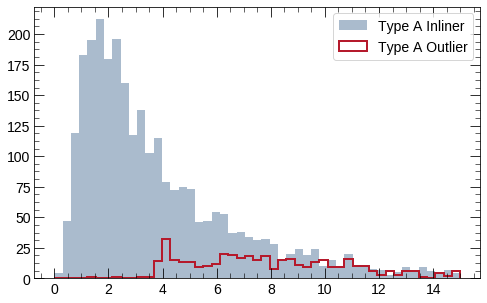

In [50]:
get_distribution(distance_type_a_inlier,
                 distance_type_a_outlier,
                 'Type A Inliner',
                 'Type A Outlier', 15)

In [51]:
# Generate test data

anomaly_scores_type_b = []
y_test_type_b = []

# x_test_random_group, k_test_random_group = generate_good()
# for i, j in enumerate(np.round(np.random.uniform(0,4,x_test_random_group.shape[0]))):
#     np.put(x_test_random_group, [i*6 + j, i*6 + j + 4, i*6 + j + 8, i*6 + j + 12, i*6 + j + 16, i*6 + j + 20], np.random.normal(loc=3*std, scale=0., size=(6)))

# x_test_correlated_group, k_test_correlated_group = generate_good()
# for i, j in enumerate(np.round(np.random.uniform(0,3,x_test_correlated_group.shape[0]))):
#     for k in range(6):
#         np.put(x_test_correlated_group, [i*24 + j*6+k], np.random.normal(loc=3*std, scale=0.))

x_test_random_group, k_test_random_group = generate_good()
std = np.std(x_test_random_group)
values = np.random.normal(loc=3*std, scale=0.01, size=(6))
for i in range(x_test_random_group.shape[0]):
    feature_index = np.random.choice(np.arange(24), 6, replace=False)
    x_test_random_group[i][feature_index] = values
    
x_test_correlated_group, k_test_correlated_group = generate_good()
std = np.std(x_test_correlated_group)
values = np.random.normal(loc=3*std, scale=0.01, size=(6))
for i in range(x_test_correlated_group.shape[0]):
    group = np.random.randint(4)
    feature_index = np.arange(6*group, 6*group+6, dtype=int)
    x_test_correlated_group[i][feature_index] = values
        
for i in range(VALIDATIONS):
   
    z_enc = vaes_encoder[i].predict([x_test_random_group, k_test_random_group])
    distance_type_b_inlier = np.mean(-0.5*(1+z_enc[1]-z_enc[0]**2-np.exp(z_enc[1])), axis=1)
    
    z_enc = vaes_encoder[i].predict([x_test_correlated_group, k_test_correlated_group])
    distance_type_b_outlier = np.mean(-0.5*(1+z_enc[1]-z_enc[0]**2-np.exp(z_enc[1])), axis=1)
    
    anomaly_scores_type_b.append(np.concatenate([distance_type_b_outlier,
                                                 distance_type_b_inlier]))
    y_test_type_b.append(np.concatenate([np.ones(len(distance_type_b_outlier)),
                                         np.zeros(len(distance_type_b_inlier))]))

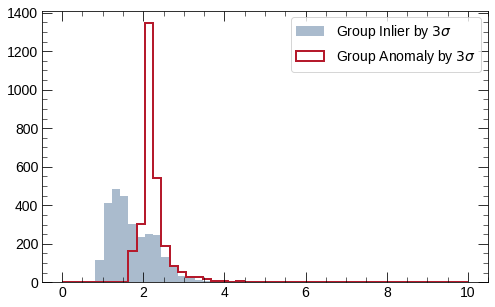

In [52]:
get_distribution(distance_type_b_inlier,
                 distance_type_b_outlier,
                 'Group Inlier by $3\sigma$',
                 'Group Anomaly by $3\sigma$',
                 10)

In [53]:
# Generate test data

anomaly_scores_type_c = []
y_test_type_c = []

x_test_random_group, k_test_random_group = generate_good()
std = np.std(x_test_random_group)
values = np.random.normal(loc=3*std, scale=0.01, size=(6))
for i in range(x_test_random_group.shape[0]):
    feature_index = np.random.choice(np.arange(24), 6, replace=False)
    x_test_random_group[i][feature_index] = values
    
x_test_correlated_group, k_test_correlated_group = generate_good()
std = np.std(x_test_correlated_group)
values = np.random.normal(loc=3*std, scale=0.01, size=(6))
for i in range(x_test_correlated_group.shape[0]):
    group = np.random.randint(4)
    feature_index = np.arange(6*group, 6*group+6, dtype=int)
    x_test_correlated_group[i][feature_index] = values
    
for i in range(VALIDATIONS):
   
    z_enc = standard_vaes_encoder[i].predict([x_test_random_group])
    distance_type_c_inlier = np.mean(-0.5*(1+z_enc[1]-z_enc[0]**2-np.exp(z_enc[1])), axis=1)
    
    z_enc = standard_vaes_encoder[i].predict([x_test_correlated_group])
    distance_type_c_outlier = np.mean(-0.5*(1+z_enc[1]-z_enc[0]**2-np.exp(z_enc[1])), axis=1)
    
    anomaly_scores_type_c.append(np.concatenate([distance_type_c_outlier,
                                                 distance_type_c_inlier]))
    y_test_type_c.append(np.concatenate([np.ones(len(distance_type_c_outlier)),
                                         np.zeros(len(distance_type_c_inlier))]))

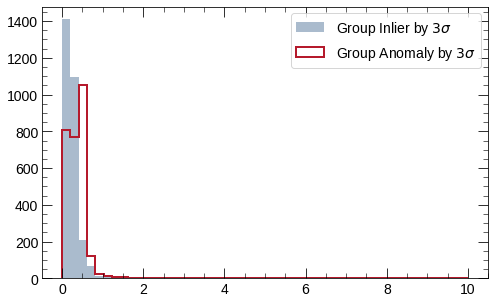

In [54]:
get_distribution(distance_type_c_inlier,
                 distance_type_c_outlier,
                 'Group Inlier by $3\sigma$',
                 'Group Anomaly by $3\sigma$',
                 10)

[0.9806954081632654, 0.9820320153061224, 0.993699362244898, 0.9930331632653061, 0.9729038265306122]
[0.8067024234693877, 0.8308413903061224, 0.8987110969387754, 0.8069205357142857, 0.7847378826530612]
[0.6886253826530613, 0.6731329081632653, 0.664878443877551, 0.6680716198979592, 0.677811224489796]


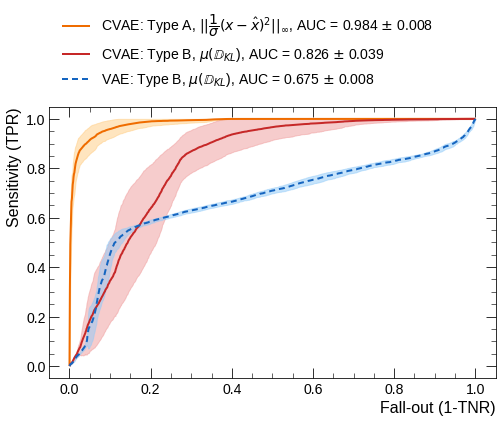

In [69]:
get_roc_curve([anomaly_scores_type_a, anomaly_scores_type_b, anomaly_scores_type_c],
              [y_test_type_a, y_test_type_b, y_test_type_c],
              ["CVAE: Type A, $||\dfrac{1}{\sigma}(x-\hat{x})^2||_{\infty}$",
               "CVAE: Type B, $\mu(\mathbb{D}_{KL}$)",
               "VAE: Type B, $\mu(\mathbb{D}_{KL}$)"],
              save_name="trigger-rate-roc")